# Deep Convolutional WGANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [2]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [4]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

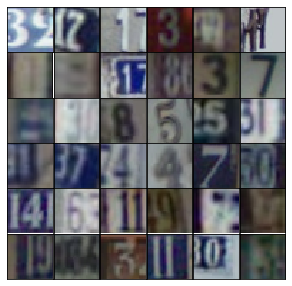

In [5]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [6]:
def scale(x, feature_range=(-1, 1)): # tanh
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range (-1, 1)
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [7]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(self.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

## Network Inputs

Here, just creating some placeholders like normal.

In [8]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3.

In [9]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding='same')
        # 32x32x3 now
        
        out = tf.tanh(logits)
        
        return out

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've build before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU. 

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

In [10]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        
        return logits

## Model Loss

Calculating the loss like before, nothing new here.

In [18]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    input_gen = generator(input_z, output_dim, alpha=alpha)
    Qlogits = discriminator(input_real, alpha=alpha)
    gQlogits = discriminator(input_gen, alpha=alpha, reuse=True)

    #     d_loss_real = tf.reduce_mean(
    #         tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    #     d_loss_fake = tf.reduce_mean(
    #         tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    #     g_loss = tf.reduce_mean(
    #         tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    #     d_loss = d_loss_real + d_loss_fake
    
    #d_loss = tf.reduce_mean(tf.square(Qlogits - gQlogits))
    d_loss = tf.reduce_mean(gQlogits-Qlogits) 
    g_loss = -tf.reduce_mean(gQlogits)

    return d_loss, g_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [19]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [20]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, real_size[2], alpha=alpha)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

Here is a function for displaying generated images.

In [21]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an error without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [22]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
                
                if len(x) != batch_size:
                    print(batch_z.shape, x.shape)
                    
                else:
                    # Run optimizers
                    dloss, _ = sess.run([net.d_loss, net.d_opt], feed_dict={net.input_real: x, net.input_z: batch_z})
                    gloss, _ = sess.run([net.g_loss, net.g_opt], feed_dict={net.input_real: x, net.input_z: batch_z})

                    steps += 1
                    if steps % print_every == 0:
                        # # At the end of each epoch, get the losses and print them out
                        # train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                        # train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                        print("Epoch {}/{}...".format(e+1, epochs),
                              "Discriminator Loss: {:.4f}...".format(dloss),
                              "Generator Loss: {:.4f}".format(gloss))
                        # Save losses to view after training
                        losses.append((dloss, gloss))

                    if steps % show_every == 0:
                        gen_samples = sess.run(
                                       generator(net.input_z, 3, reuse=True, training=False),
                                       feed_dict={net.input_z: sample_z})
                        samples.append(gen_samples)
                        _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                        plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

        with open('samples.pkl', 'wb') as f:
            pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

In [23]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 100
alpha = 0.2
beta1 = 0.5

tf.reset_default_graph()

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

dataset = Dataset(trainset, testset)

Epoch 1/100... Discriminator Loss: -3.6331... Generator Loss: 4.8319
Epoch 1/100... Discriminator Loss: -20.3848... Generator Loss: 20.0110
Epoch 1/100... Discriminator Loss: -40.0433... Generator Loss: 31.9273
Epoch 1/100... Discriminator Loss: -68.5701... Generator Loss: 43.6022
Epoch 1/100... Discriminator Loss: -73.7473... Generator Loss: 46.5646
Epoch 1/100... Discriminator Loss: -89.2579... Generator Loss: 51.2542
Epoch 1/100... Discriminator Loss: -72.2473... Generator Loss: 49.6111
Epoch 1/100... Discriminator Loss: -26.2003... Generator Loss: 33.6326
Epoch 1/100... Discriminator Loss: -40.2271... Generator Loss: 40.0311
Epoch 1/100... Discriminator Loss: -63.4081... Generator Loss: 46.2002


/home/arasdar/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1324: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


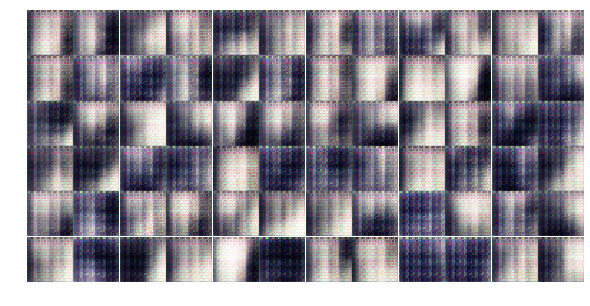

Epoch 1/100... Discriminator Loss: -53.1497... Generator Loss: 47.4974
Epoch 1/100... Discriminator Loss: -115.2623... Generator Loss: 66.3896
Epoch 1/100... Discriminator Loss: -109.8722... Generator Loss: 60.5543
Epoch 1/100... Discriminator Loss: -71.1872... Generator Loss: 50.5173
Epoch 1/100... Discriminator Loss: -52.9053... Generator Loss: 41.8544
Epoch 1/100... Discriminator Loss: -65.2999... Generator Loss: 40.5345
Epoch 1/100... Discriminator Loss: -84.6667... Generator Loss: 51.3982
Epoch 1/100... Discriminator Loss: -64.2537... Generator Loss: 62.4689
Epoch 1/100... Discriminator Loss: -31.1709... Generator Loss: 65.7446
Epoch 1/100... Discriminator Loss: -45.4206... Generator Loss: 70.6653


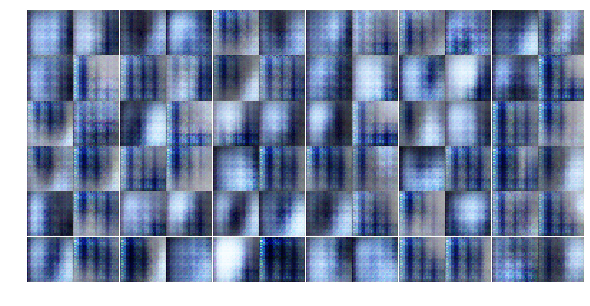

Epoch 1/100... Discriminator Loss: -96.4426... Generator Loss: 71.7858
Epoch 1/100... Discriminator Loss: -79.8132... Generator Loss: 83.0111
Epoch 1/100... Discriminator Loss: -58.8652... Generator Loss: 68.1468
Epoch 1/100... Discriminator Loss: -50.7175... Generator Loss: 63.9491
Epoch 1/100... Discriminator Loss: -108.4693... Generator Loss: 71.3798
Epoch 1/100... Discriminator Loss: -72.9913... Generator Loss: 96.4248
Epoch 1/100... Discriminator Loss: -70.5894... Generator Loss: 90.4425
Epoch 1/100... Discriminator Loss: -152.1319... Generator Loss: 93.1032
Epoch 1/100... Discriminator Loss: -94.8545... Generator Loss: 88.3606
Epoch 1/100... Discriminator Loss: -92.0465... Generator Loss: 66.2608


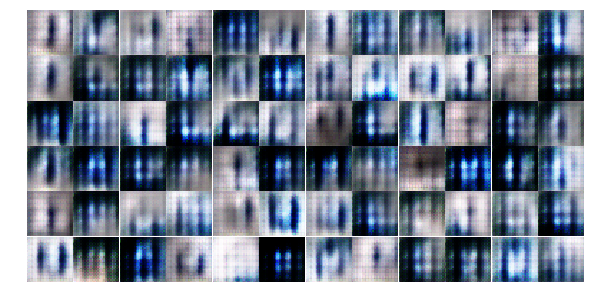

Epoch 1/100... Discriminator Loss: -105.7107... Generator Loss: 79.8835
Epoch 1/100... Discriminator Loss: -156.3888... Generator Loss: 111.4814
Epoch 1/100... Discriminator Loss: -98.3787... Generator Loss: 98.2630
Epoch 1/100... Discriminator Loss: -185.5289... Generator Loss: 119.9239
Epoch 1/100... Discriminator Loss: -162.7567... Generator Loss: 91.4071
Epoch 1/100... Discriminator Loss: -216.9637... Generator Loss: 109.0664
Epoch 1/100... Discriminator Loss: -185.5853... Generator Loss: 121.9669
Epoch 1/100... Discriminator Loss: 6.2329... Generator Loss: -141.3298
Epoch 1/100... Discriminator Loss: 0.2249... Generator Loss: -153.0309
Epoch 1/100... Discriminator Loss: -7.7327... Generator Loss: -135.4198


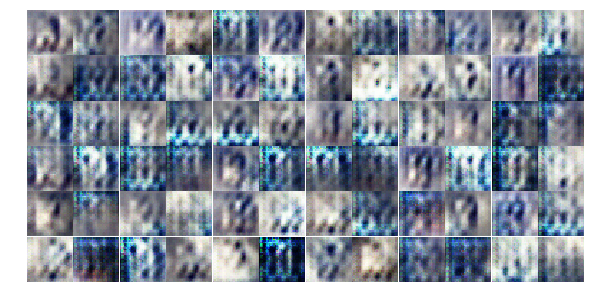

Epoch 1/100... Discriminator Loss: -4.9364... Generator Loss: -112.6040
Epoch 1/100... Discriminator Loss: -63.7371... Generator Loss: -9.7132
Epoch 1/100... Discriminator Loss: -27.7881... Generator Loss: -9.0580
Epoch 1/100... Discriminator Loss: -20.4187... Generator Loss: 50.6499
Epoch 1/100... Discriminator Loss: -31.8567... Generator Loss: 70.8347
Epoch 1/100... Discriminator Loss: -79.6900... Generator Loss: 91.2425
Epoch 1/100... Discriminator Loss: -74.1721... Generator Loss: 75.7551
Epoch 1/100... Discriminator Loss: 42.3800... Generator Loss: 16.1438
Epoch 1/100... Discriminator Loss: -19.9042... Generator Loss: -37.1757
Epoch 1/100... Discriminator Loss: 39.9156... Generator Loss: -106.9252


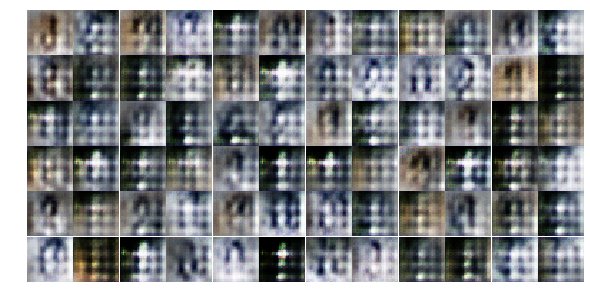

Epoch 1/100... Discriminator Loss: -30.5842... Generator Loss: 0.0314
Epoch 1/100... Discriminator Loss: 25.3584... Generator Loss: -70.5812
Epoch 1/100... Discriminator Loss: -16.2019... Generator Loss: -19.6158
Epoch 1/100... Discriminator Loss: -1.4037... Generator Loss: 48.3123
Epoch 1/100... Discriminator Loss: 25.9782... Generator Loss: -76.5320
Epoch 1/100... Discriminator Loss: -13.2923... Generator Loss: -36.2393
Epoch 1/100... Discriminator Loss: 8.8892... Generator Loss: -72.4094
(128, 100) (41, 32, 32, 3)
Epoch 2/100... Discriminator Loss: 12.4174... Generator Loss: 23.9770
Epoch 2/100... Discriminator Loss: 15.8443... Generator Loss: -75.5478
Epoch 2/100... Discriminator Loss: -33.0886... Generator Loss: -14.2550


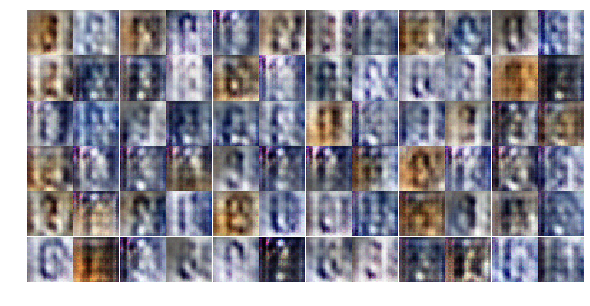

Epoch 2/100... Discriminator Loss: 20.8098... Generator Loss: -51.3604
Epoch 2/100... Discriminator Loss: 13.6063... Generator Loss: -34.5935
Epoch 2/100... Discriminator Loss: 0.2314... Generator Loss: 3.7432
Epoch 2/100... Discriminator Loss: 10.2922... Generator Loss: -12.3565
Epoch 2/100... Discriminator Loss: -34.8102... Generator Loss: 29.4613
Epoch 2/100... Discriminator Loss: 5.3994... Generator Loss: 22.6009
Epoch 2/100... Discriminator Loss: -6.1425... Generator Loss: 71.8380
Epoch 2/100... Discriminator Loss: -23.3329... Generator Loss: 71.4183
Epoch 2/100... Discriminator Loss: -8.9705... Generator Loss: 38.5289
Epoch 2/100... Discriminator Loss: -28.0479... Generator Loss: 52.1287


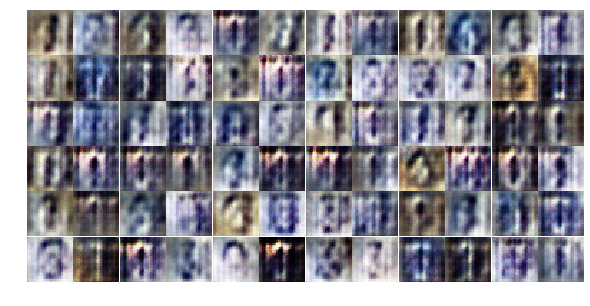

Epoch 2/100... Discriminator Loss: -15.3627... Generator Loss: 60.8131
Epoch 2/100... Discriminator Loss: -12.9861... Generator Loss: 32.0293
Epoch 2/100... Discriminator Loss: -20.4978... Generator Loss: 70.5685
Epoch 2/100... Discriminator Loss: -56.6067... Generator Loss: 79.0835
Epoch 2/100... Discriminator Loss: -39.1479... Generator Loss: 73.5093
Epoch 2/100... Discriminator Loss: -25.2110... Generator Loss: 62.4029
Epoch 2/100... Discriminator Loss: -7.9847... Generator Loss: 80.1886
Epoch 2/100... Discriminator Loss: -46.6666... Generator Loss: 80.1105
Epoch 2/100... Discriminator Loss: -9.5015... Generator Loss: 35.5539
Epoch 2/100... Discriminator Loss: 8.5530... Generator Loss: 10.6342


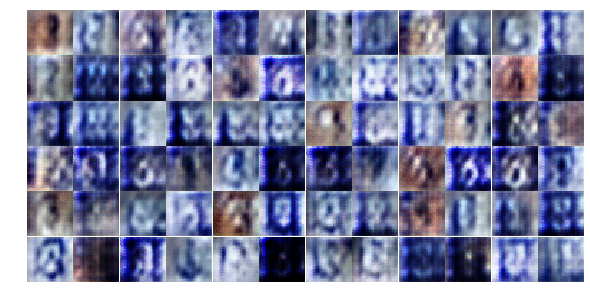

Epoch 2/100... Discriminator Loss: -8.8598... Generator Loss: 31.5070
Epoch 2/100... Discriminator Loss: -40.0977... Generator Loss: 21.7975
Epoch 2/100... Discriminator Loss: 1.3466... Generator Loss: 1.1423
Epoch 2/100... Discriminator Loss: -46.9423... Generator Loss: 71.0438
Epoch 2/100... Discriminator Loss: -40.5017... Generator Loss: 31.0543
Epoch 2/100... Discriminator Loss: -28.1450... Generator Loss: 27.9565
Epoch 2/100... Discriminator Loss: -45.6294... Generator Loss: 84.4617
Epoch 2/100... Discriminator Loss: -32.2115... Generator Loss: 73.6747
Epoch 2/100... Discriminator Loss: -58.7481... Generator Loss: 78.6488
Epoch 2/100... Discriminator Loss: -33.5596... Generator Loss: 78.1658


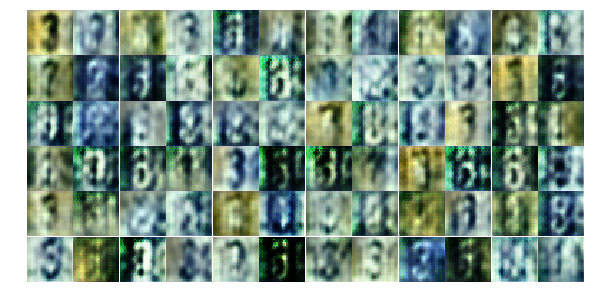

Epoch 2/100... Discriminator Loss: 65.8209... Generator Loss: -84.7208
Epoch 2/100... Discriminator Loss: -36.0486... Generator Loss: 23.8590
Epoch 2/100... Discriminator Loss: 14.4353... Generator Loss: 46.5216
Epoch 2/100... Discriminator Loss: -72.8471... Generator Loss: 79.1739
Epoch 2/100... Discriminator Loss: -29.3483... Generator Loss: 20.3466
Epoch 2/100... Discriminator Loss: -4.7127... Generator Loss: 37.7367
Epoch 2/100... Discriminator Loss: -21.4442... Generator Loss: 83.3315
Epoch 2/100... Discriminator Loss: -38.8122... Generator Loss: 86.6087
Epoch 2/100... Discriminator Loss: -24.3802... Generator Loss: 74.1050
Epoch 2/100... Discriminator Loss: -40.1077... Generator Loss: 41.9844


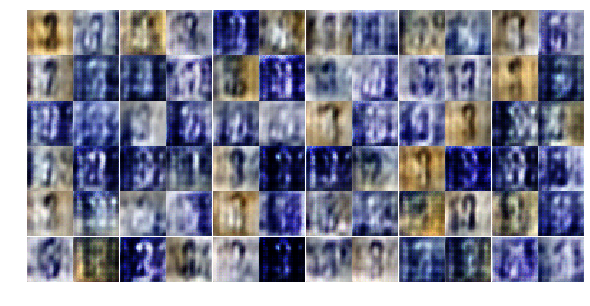

Epoch 2/100... Discriminator Loss: -17.5505... Generator Loss: -10.6916
Epoch 2/100... Discriminator Loss: -19.3528... Generator Loss: 45.0249
Epoch 2/100... Discriminator Loss: -19.4101... Generator Loss: -29.1196
Epoch 2/100... Discriminator Loss: -8.9578... Generator Loss: 0.6802
Epoch 2/100... Discriminator Loss: -61.9248... Generator Loss: 61.9992
Epoch 2/100... Discriminator Loss: 8.9388... Generator Loss: 4.2332
Epoch 2/100... Discriminator Loss: -18.6117... Generator Loss: 1.9300
Epoch 2/100... Discriminator Loss: -53.7077... Generator Loss: 69.9667
Epoch 2/100... Discriminator Loss: -8.3229... Generator Loss: 49.0656
Epoch 2/100... Discriminator Loss: -12.8455... Generator Loss: 77.3039


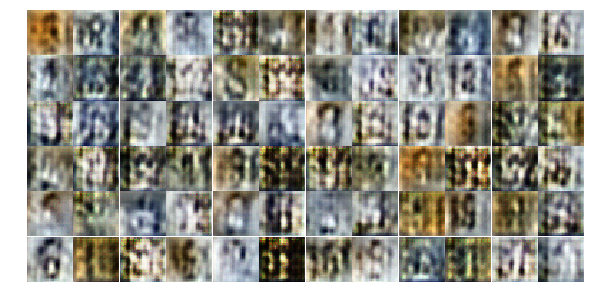

Epoch 2/100... Discriminator Loss: -14.4342... Generator Loss: 63.4399
Epoch 2/100... Discriminator Loss: -31.5868... Generator Loss: 71.0686
Epoch 2/100... Discriminator Loss: 40.5484... Generator Loss: 76.3326
Epoch 2/100... Discriminator Loss: -43.5070... Generator Loss: 95.1796
(128, 100) (41, 32, 32, 3)
Epoch 3/100... Discriminator Loss: -1.2731... Generator Loss: 34.3155
Epoch 3/100... Discriminator Loss: 3.3707... Generator Loss: 41.4811
Epoch 3/100... Discriminator Loss: -5.9539... Generator Loss: 34.2522
Epoch 3/100... Discriminator Loss: 15.1699... Generator Loss: 16.7248
Epoch 3/100... Discriminator Loss: -9.6680... Generator Loss: 46.4038
Epoch 3/100... Discriminator Loss: -39.1218... Generator Loss: 103.6891


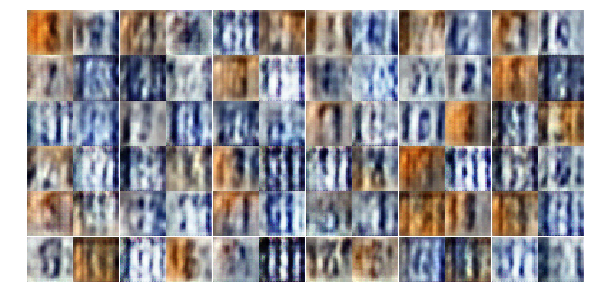

Epoch 3/100... Discriminator Loss: 16.7766... Generator Loss: 48.3760
Epoch 3/100... Discriminator Loss: -31.6344... Generator Loss: 95.8684
Epoch 3/100... Discriminator Loss: -10.7824... Generator Loss: 64.2528
Epoch 3/100... Discriminator Loss: -22.9307... Generator Loss: 55.4445
Epoch 3/100... Discriminator Loss: 1.5534... Generator Loss: 42.8397
Epoch 3/100... Discriminator Loss: -21.1211... Generator Loss: 94.2647
Epoch 3/100... Discriminator Loss: -18.0868... Generator Loss: 106.7506
Epoch 3/100... Discriminator Loss: -17.2428... Generator Loss: 59.1727
Epoch 3/100... Discriminator Loss: -11.1105... Generator Loss: 36.8800
Epoch 3/100... Discriminator Loss: -6.2355... Generator Loss: 46.0658


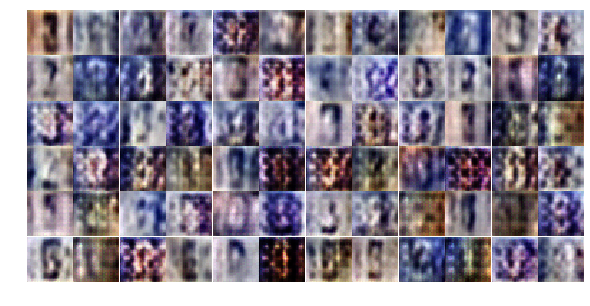

Epoch 3/100... Discriminator Loss: -9.3017... Generator Loss: 96.4148
Epoch 3/100... Discriminator Loss: -2.4031... Generator Loss: 43.9124
Epoch 3/100... Discriminator Loss: -5.7088... Generator Loss: 8.2610
Epoch 3/100... Discriminator Loss: -3.8087... Generator Loss: 64.0717
Epoch 3/100... Discriminator Loss: -9.5835... Generator Loss: 51.4639
Epoch 3/100... Discriminator Loss: -23.3775... Generator Loss: 90.8375
Epoch 3/100... Discriminator Loss: -18.8583... Generator Loss: 20.3833
Epoch 3/100... Discriminator Loss: -33.6959... Generator Loss: 21.2187
Epoch 3/100... Discriminator Loss: -16.2736... Generator Loss: 74.8455
Epoch 3/100... Discriminator Loss: -6.7588... Generator Loss: 23.8160


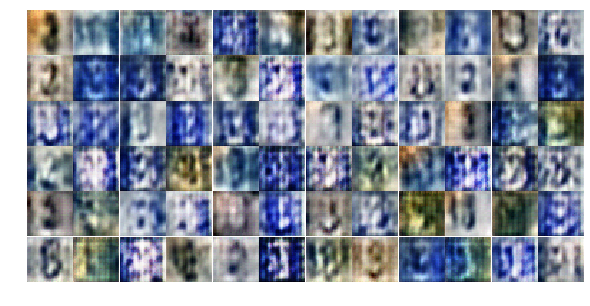

Epoch 3/100... Discriminator Loss: -17.6607... Generator Loss: 57.5898
Epoch 3/100... Discriminator Loss: -5.2056... Generator Loss: 40.2456
Epoch 3/100... Discriminator Loss: -21.1556... Generator Loss: 48.3526
Epoch 3/100... Discriminator Loss: -13.6538... Generator Loss: 62.4597
Epoch 3/100... Discriminator Loss: -1.8758... Generator Loss: 79.7734
Epoch 3/100... Discriminator Loss: -19.2551... Generator Loss: 76.3944
Epoch 3/100... Discriminator Loss: -28.9455... Generator Loss: 63.6922
Epoch 3/100... Discriminator Loss: -16.2830... Generator Loss: 34.3004
Epoch 3/100... Discriminator Loss: 9.6886... Generator Loss: 71.4073
Epoch 3/100... Discriminator Loss: -3.3159... Generator Loss: 62.6462


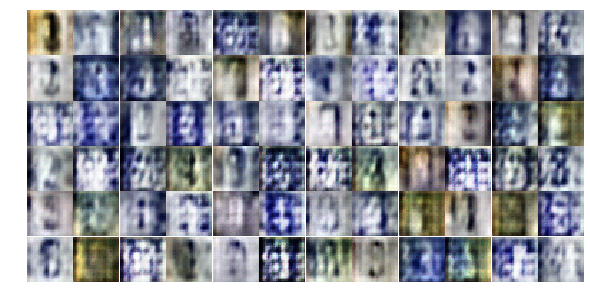

Epoch 3/100... Discriminator Loss: -18.2007... Generator Loss: 67.0707
Epoch 3/100... Discriminator Loss: 16.2020... Generator Loss: 51.6938
Epoch 3/100... Discriminator Loss: -34.3221... Generator Loss: 89.4422
Epoch 3/100... Discriminator Loss: 32.8875... Generator Loss: 77.1860
Epoch 3/100... Discriminator Loss: -29.8775... Generator Loss: 86.5222
Epoch 3/100... Discriminator Loss: -15.9164... Generator Loss: 16.8530
Epoch 3/100... Discriminator Loss: 6.0033... Generator Loss: 10.5623
Epoch 3/100... Discriminator Loss: 8.4450... Generator Loss: 7.4464
Epoch 3/100... Discriminator Loss: -16.7933... Generator Loss: 81.3223
Epoch 3/100... Discriminator Loss: -24.8250... Generator Loss: 66.6364


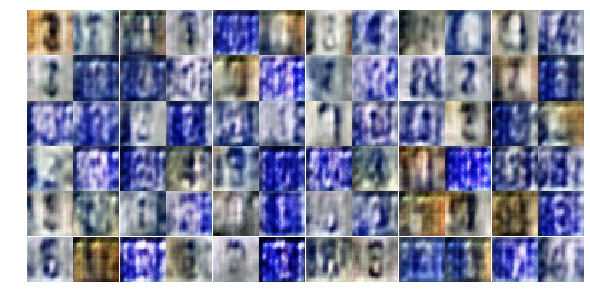

Epoch 3/100... Discriminator Loss: 20.6508... Generator Loss: 53.5544
Epoch 3/100... Discriminator Loss: 12.2852... Generator Loss: 79.3865
Epoch 3/100... Discriminator Loss: -47.6108... Generator Loss: 91.9481
Epoch 3/100... Discriminator Loss: 3.2120... Generator Loss: 59.8501
Epoch 3/100... Discriminator Loss: -20.1392... Generator Loss: 97.2570
Epoch 3/100... Discriminator Loss: -3.0580... Generator Loss: 76.5140
Epoch 3/100... Discriminator Loss: -4.7466... Generator Loss: 61.4631
Epoch 3/100... Discriminator Loss: 4.6113... Generator Loss: 50.4250
Epoch 3/100... Discriminator Loss: -58.9383... Generator Loss: 70.2346
Epoch 3/100... Discriminator Loss: 27.4033... Generator Loss: 45.4881


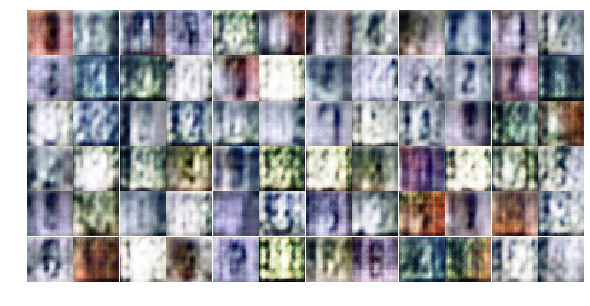

Epoch 3/100... Discriminator Loss: -12.1687... Generator Loss: 75.1131
(128, 100) (41, 32, 32, 3)
Epoch 4/100... Discriminator Loss: -12.4660... Generator Loss: 41.1605
Epoch 4/100... Discriminator Loss: -14.8198... Generator Loss: 40.9243
Epoch 4/100... Discriminator Loss: 17.6762... Generator Loss: 63.9098
Epoch 4/100... Discriminator Loss: -15.2065... Generator Loss: 68.4882
Epoch 4/100... Discriminator Loss: -10.4467... Generator Loss: 74.6812
Epoch 4/100... Discriminator Loss: 11.4308... Generator Loss: 54.3674
Epoch 4/100... Discriminator Loss: -35.8063... Generator Loss: 42.2472
Epoch 4/100... Discriminator Loss: -40.7320... Generator Loss: 92.2735
Epoch 4/100... Discriminator Loss: -3.7756... Generator Loss: 59.9352


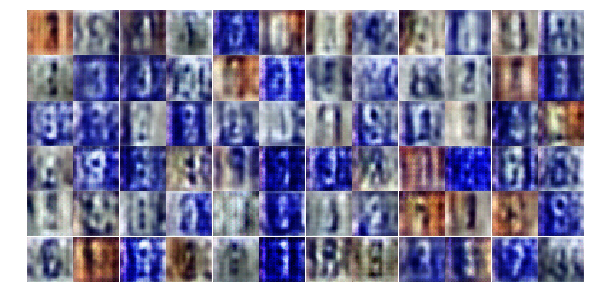

Epoch 4/100... Discriminator Loss: -3.5194... Generator Loss: 28.4017
Epoch 4/100... Discriminator Loss: -19.7016... Generator Loss: 95.3508
Epoch 4/100... Discriminator Loss: 8.1873... Generator Loss: 27.9834
Epoch 4/100... Discriminator Loss: -29.3931... Generator Loss: 80.4350
Epoch 4/100... Discriminator Loss: -6.7704... Generator Loss: 35.0258
Epoch 4/100... Discriminator Loss: -32.4011... Generator Loss: 36.7763
Epoch 4/100... Discriminator Loss: 37.6450... Generator Loss: -15.8341
Epoch 4/100... Discriminator Loss: -54.0282... Generator Loss: 111.1182
Epoch 4/100... Discriminator Loss: 16.8100... Generator Loss: 43.0661
Epoch 4/100... Discriminator Loss: -85.7032... Generator Loss: 29.0161


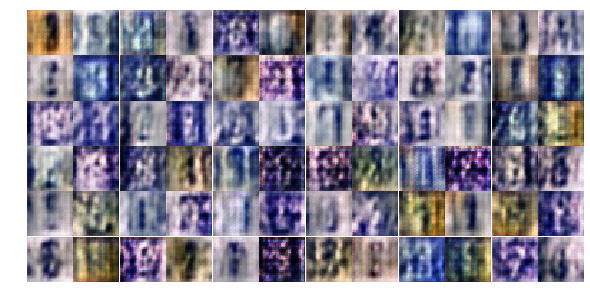

Epoch 4/100... Discriminator Loss: 12.5937... Generator Loss: 61.8860
Epoch 4/100... Discriminator Loss: -1.8060... Generator Loss: 79.3738
Epoch 4/100... Discriminator Loss: 1.2836... Generator Loss: 80.5156
Epoch 4/100... Discriminator Loss: -36.1892... Generator Loss: 69.4574
Epoch 4/100... Discriminator Loss: 1.0699... Generator Loss: 29.3747
Epoch 4/100... Discriminator Loss: -24.9286... Generator Loss: 57.3550
Epoch 4/100... Discriminator Loss: -14.3944... Generator Loss: 80.6247
Epoch 4/100... Discriminator Loss: -22.4182... Generator Loss: 54.4670
Epoch 4/100... Discriminator Loss: 4.4058... Generator Loss: 46.5787
Epoch 4/100... Discriminator Loss: -5.3617... Generator Loss: 53.8032


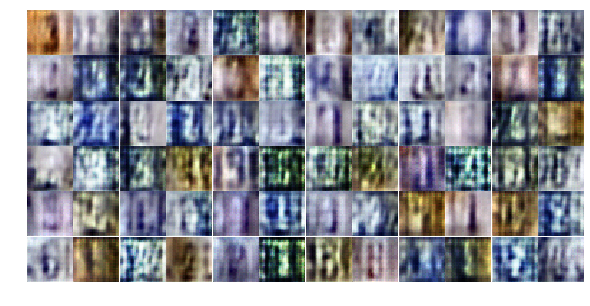

Epoch 4/100... Discriminator Loss: -20.9574... Generator Loss: 64.4660
Epoch 4/100... Discriminator Loss: 7.9050... Generator Loss: 18.9519
Epoch 4/100... Discriminator Loss: 9.0854... Generator Loss: -0.7697
Epoch 4/100... Discriminator Loss: -4.1510... Generator Loss: 83.5826
Epoch 4/100... Discriminator Loss: -19.7083... Generator Loss: 40.3955
Epoch 4/100... Discriminator Loss: -19.2009... Generator Loss: 79.6782
Epoch 4/100... Discriminator Loss: -11.0267... Generator Loss: 28.2736
Epoch 4/100... Discriminator Loss: -32.0063... Generator Loss: 36.8258
Epoch 4/100... Discriminator Loss: -11.9387... Generator Loss: 108.7172
Epoch 4/100... Discriminator Loss: -36.4332... Generator Loss: 68.6406


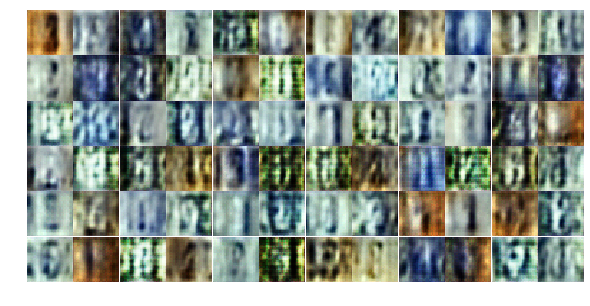

Epoch 4/100... Discriminator Loss: -5.7294... Generator Loss: 139.7408
Epoch 4/100... Discriminator Loss: -33.3074... Generator Loss: 27.7590
Epoch 4/100... Discriminator Loss: 10.0706... Generator Loss: 55.7427
Epoch 4/100... Discriminator Loss: -49.2536... Generator Loss: 130.6967
Epoch 4/100... Discriminator Loss: -4.0391... Generator Loss: 18.1281
Epoch 4/100... Discriminator Loss: -25.7056... Generator Loss: 69.7984
Epoch 4/100... Discriminator Loss: -48.0286... Generator Loss: 114.5266
Epoch 4/100... Discriminator Loss: -60.9853... Generator Loss: 103.9197
Epoch 4/100... Discriminator Loss: -19.1985... Generator Loss: 75.1712
Epoch 4/100... Discriminator Loss: -19.7968... Generator Loss: 22.0187


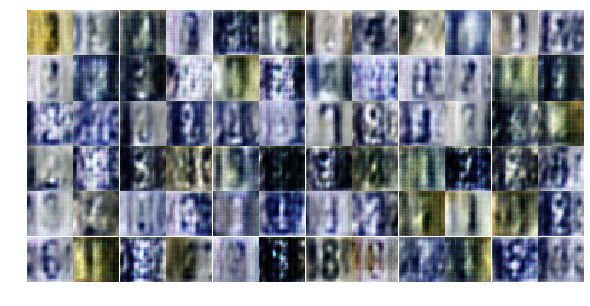

Epoch 4/100... Discriminator Loss: -79.1437... Generator Loss: 117.9000
Epoch 4/100... Discriminator Loss: -2.2403... Generator Loss: 66.4672
Epoch 4/100... Discriminator Loss: -20.1585... Generator Loss: 35.8921
Epoch 4/100... Discriminator Loss: -93.3503... Generator Loss: 121.4624
Epoch 4/100... Discriminator Loss: -49.0510... Generator Loss: 55.5886
Epoch 4/100... Discriminator Loss: 41.0342... Generator Loss: -108.0739
Epoch 4/100... Discriminator Loss: -81.5008... Generator Loss: 105.9490
Epoch 4/100... Discriminator Loss: 13.4464... Generator Loss: 124.7777
(128, 100) (41, 32, 32, 3)
Epoch 5/100... Discriminator Loss: 0.6017... Generator Loss: 28.7161
Epoch 5/100... Discriminator Loss: -34.3200... Generator Loss: 17.8772


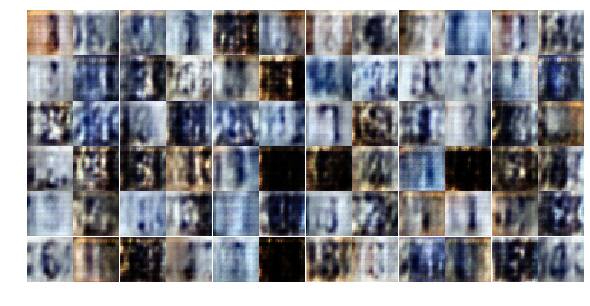

Epoch 5/100... Discriminator Loss: 4.0700... Generator Loss: 34.7875
Epoch 5/100... Discriminator Loss: 29.2808... Generator Loss: 27.7833
Epoch 5/100... Discriminator Loss: -20.0074... Generator Loss: 67.5034
Epoch 5/100... Discriminator Loss: -1.6977... Generator Loss: 92.8942
Epoch 5/100... Discriminator Loss: -9.7968... Generator Loss: 32.9934
Epoch 5/100... Discriminator Loss: -45.9429... Generator Loss: 40.3987
Epoch 5/100... Discriminator Loss: -39.5913... Generator Loss: 113.2329
Epoch 5/100... Discriminator Loss: -58.5592... Generator Loss: 118.9397
Epoch 5/100... Discriminator Loss: -5.5900... Generator Loss: 128.4317
Epoch 5/100... Discriminator Loss: -17.4825... Generator Loss: 80.2484


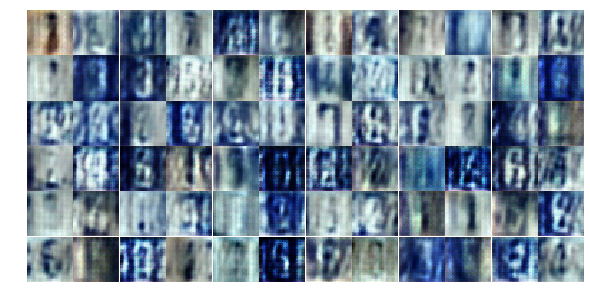

Epoch 5/100... Discriminator Loss: -38.5195... Generator Loss: 172.5847
Epoch 5/100... Discriminator Loss: -12.8837... Generator Loss: -31.8315
Epoch 5/100... Discriminator Loss: -8.3195... Generator Loss: 123.0989
Epoch 5/100... Discriminator Loss: -25.1178... Generator Loss: 71.8971
Epoch 5/100... Discriminator Loss: -143.0237... Generator Loss: 170.6988
Epoch 5/100... Discriminator Loss: -44.2977... Generator Loss: 54.6956
Epoch 5/100... Discriminator Loss: -107.2814... Generator Loss: 113.1248
Epoch 5/100... Discriminator Loss: -9.9949... Generator Loss: 218.3367
Epoch 5/100... Discriminator Loss: -6.3492... Generator Loss: 270.4981
Epoch 5/100... Discriminator Loss: -16.7439... Generator Loss: 263.3196


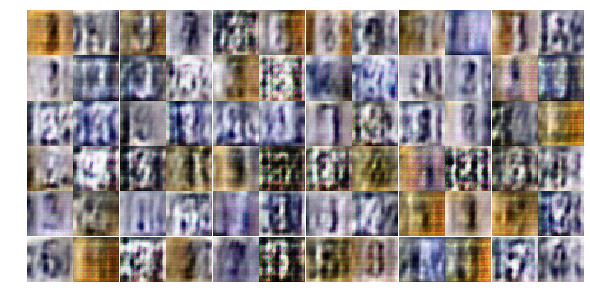

Epoch 5/100... Discriminator Loss: -7.6099... Generator Loss: 67.7322
Epoch 5/100... Discriminator Loss: -67.3204... Generator Loss: 130.0421
Epoch 5/100... Discriminator Loss: -120.1315... Generator Loss: 161.7616
Epoch 5/100... Discriminator Loss: -71.8687... Generator Loss: 230.4827
Epoch 5/100... Discriminator Loss: 34.2154... Generator Loss: 254.6816
Epoch 5/100... Discriminator Loss: -28.1031... Generator Loss: 268.8883
Epoch 5/100... Discriminator Loss: -8.3052... Generator Loss: 96.0126
Epoch 5/100... Discriminator Loss: -47.9585... Generator Loss: 167.9947
Epoch 5/100... Discriminator Loss: -73.5771... Generator Loss: 114.1871
Epoch 5/100... Discriminator Loss: -102.8535... Generator Loss: 83.7072


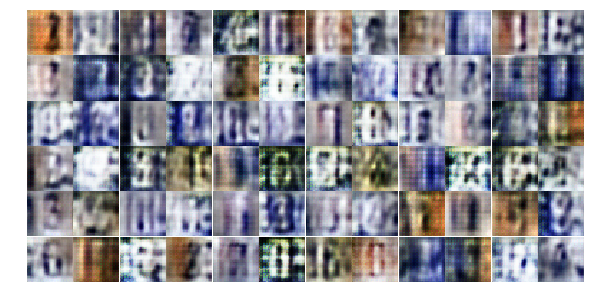

Epoch 5/100... Discriminator Loss: -43.6255... Generator Loss: -221.9060
Epoch 5/100... Discriminator Loss: 7.4398... Generator Loss: -262.1354
Epoch 5/100... Discriminator Loss: -172.6723... Generator Loss: 44.2912
Epoch 5/100... Discriminator Loss: -220.6488... Generator Loss: 59.9439
Epoch 5/100... Discriminator Loss: -253.8042... Generator Loss: 298.8582
Epoch 5/100... Discriminator Loss: -260.9908... Generator Loss: 295.0160
Epoch 5/100... Discriminator Loss: -154.6800... Generator Loss: 132.4435
Epoch 5/100... Discriminator Loss: -73.0945... Generator Loss: 177.9296
Epoch 5/100... Discriminator Loss: -9.1919... Generator Loss: 268.7111
Epoch 5/100... Discriminator Loss: -133.6734... Generator Loss: 120.9822


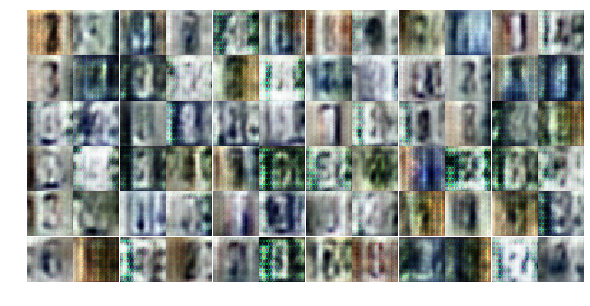

Epoch 5/100... Discriminator Loss: -298.8875... Generator Loss: 91.7586
Epoch 5/100... Discriminator Loss: -114.4649... Generator Loss: 322.7931
Epoch 5/100... Discriminator Loss: -51.7728... Generator Loss: 375.8511
Epoch 5/100... Discriminator Loss: -88.2454... Generator Loss: 338.0671
Epoch 5/100... Discriminator Loss: -198.8369... Generator Loss: 242.9957
Epoch 5/100... Discriminator Loss: -138.2375... Generator Loss: 365.0760
Epoch 5/100... Discriminator Loss: -45.8634... Generator Loss: 150.8893
Epoch 5/100... Discriminator Loss: -83.5396... Generator Loss: -19.6220
Epoch 5/100... Discriminator Loss: 66.6949... Generator Loss: 55.1087
Epoch 5/100... Discriminator Loss: -129.5789... Generator Loss: 59.4462


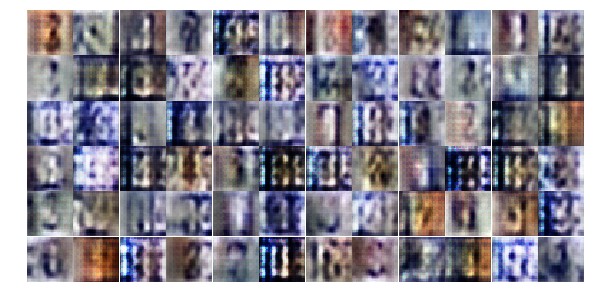

Epoch 5/100... Discriminator Loss: -234.8654... Generator Loss: 228.1586
Epoch 5/100... Discriminator Loss: -155.4066... Generator Loss: 4.2207
Epoch 5/100... Discriminator Loss: -228.4751... Generator Loss: 187.0213
Epoch 5/100... Discriminator Loss: 3.2470... Generator Loss: -261.6637
Epoch 5/100... Discriminator Loss: -112.9800... Generator Loss: 62.4268
Epoch 5/100... Discriminator Loss: -107.4790... Generator Loss: -43.9470
(128, 100) (41, 32, 32, 3)
Epoch 6/100... Discriminator Loss: -56.7166... Generator Loss: 274.9805
Epoch 6/100... Discriminator Loss: -54.5681... Generator Loss: 397.0297
Epoch 6/100... Discriminator Loss: -112.2533... Generator Loss: 55.6342
Epoch 6/100... Discriminator Loss: -55.3358... Generator Loss: 101.5477


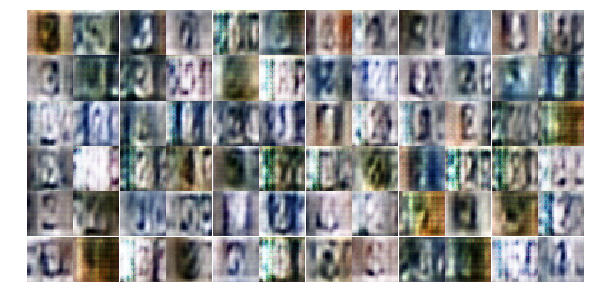

In [ ]:
losses, samples = train(net=net, dataset=dataset, epochs=epochs, batch_size=batch_size, figsize=(10,5))

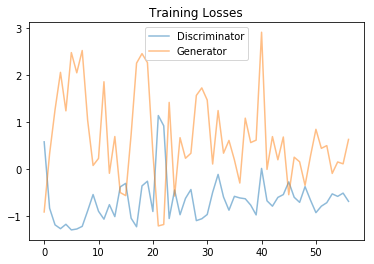

In [22]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

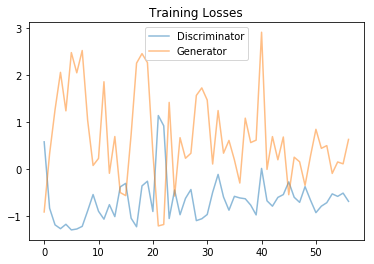

In [23]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


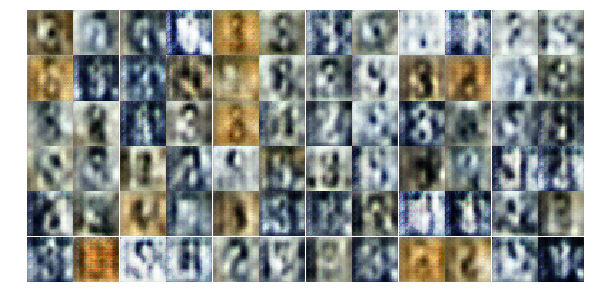

In [24]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))

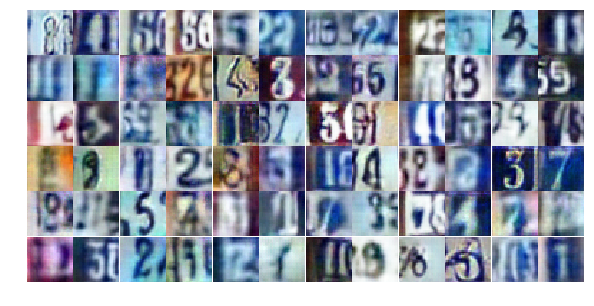

In [19]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))